# Lesson 8 Code Along

[Lesson 8 Wiki](http://forums.fast.ai/t/part-2-lesson-8-in-class/13556) | Notebook: [pascal.ipynb](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb)

---

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

## 1. Pascal VOC

We'll be looking at the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC) dataset. It's quite slow, so you may prefer to download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll use the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

Unlike previous lessons, we're using the Python 3 standard library `pathlib` for our paths and file access. Note that it returns an OS-specific class (on Unix: `PosixPath`) so your output may look a little different. Most libraries that take paths as input can take a pathlib object - although some (like cv2) can't, in which case you can use `str()` to convert to a string.

In [15]:
PATH = Path('data/pascal/')
list(PATH.iterdir())

[PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json')]

As well as images, there're also *annotations - bounding boxes* showing where each object is. These were hand labeled. The original versions were in XML, which is a little hard to work with nowadas, so we use the more recent JSON version.

`pathlib` includes the ability to open files, and much more.

Here we want to open JSON files that contain the bounding boxes and object classes. The fastest way to do this in Python is with the JSON library -- although there are Google versions for super-large files.

In [21]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

JSON - JavaScript Object Notation - is kind of a standard way to pass around hierarchical structured data now.

In [22]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [23]:
trn_j[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

Segmentation is Polygon Segmentation. We'll use bounding box.

In [24]:
trn_j[CATEGORIES][:4]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'}]

It's helpful to use constants instead of strings, since we get tab-completion and don't mistype.

We can turn this categories list from a dictionary of id -> name:

In [27]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'
cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [28]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/Annotations')]

In [29]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [30]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007594.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005682.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005016.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/001930.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007666.jpg')]

Each image has a unique ID

In [31]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME], im0_d[ID]

('000012.jpg', 12)

A `defaultdict` is useful any time you want to have a default dictionary entry for new keys. Here we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

We convert VOC's height/width into top-left/bot-right, and witch x/y coords to be consistent with NumPy. 

The idea here is to create a dictionary where the key is the image id, and the value is the list of all its annotations. So: go through each of the annotations; if it doesn't say to ignore it: append its bounding-box and class to the appropriate dictionary item (where that dictionary item is a list).

But if that dictionary item doesnt exist yet then there's no list to append to. `collections.defaultdict` which behaves just like a regular dictionary, except that if you try to access a key that does not exist, it will *make* that key exist with the default value of a function you specify -- in this case: `lambda: []`

**NOTE** that the dimensions are reversed in `hw_bb`. This is because CV usually uses W,H whereas Mathematics uses R,C. Width x Height vs Rows x Columns. FastAI follows the NumPy/PyTorch way of RxC. FastAI also uses Top-Left;Bottom-Right coordinates, instead of Top-Left;Heigh,Width.

In [34]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))
        
len(trn_anno)

2501

Now we have a dictionary of filenames -> tuple(bounding_box_coords, class_id)

In [35]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [36]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [38]:
cats[7]

'car'

In [40]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [41]:
cats[15], cats[13]

('person', 'horse')

Some libs take VOC format bounding boxes, so this let's us convert back when required:

In [101]:
def bb_hw(a): return np.array([a[1], a[0], a[3]-a[1], a[2]-a[0]+1])

In [102]:
bb_voc = [155, 96, 196, 174]
bb_fastai = hw_bb(bb_voc)

In [103]:
f'expected: {bb_voc}, actual: {bb_hw(bb_fastai)}'

'expected: [155, 96, 196, 174], actual: [155  96 195 174]'

YOu can use [Visual Studio Code](https://code.visualstudio.com/) (vscode - open source editor that comes with recent versions of Anaconda, or can be installed seperately), or mose editors and IDEs, to find out all about the `open_image` function. csvode things to know:


-    Command palette (`Ctrl-shift-p`)
-    Select interpreter (for fastai env)
-    Select terminal shell
-    Go to symbol (`Ctrl-t`)
-    Find references (`Shift-F12`)
-    Go to definition (`F12`)
-    Go back (`alt-left`)
-    View documentation
-    Hide sidebar (`Ctrl-b`)
-    Zen mode (`Ctrl-k,z`)


In [43]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

Matplotlib's `plt.subplots` is a really sueful wrapper for creating plots, regardless of whether you have more than one subplot. **NOTE** that Matplotlib has an optional object-oriented API which is much easier to understand and use (although few examples online use it).

In [104]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

A simple but rarely used trick to making text visible regardless of background is to use white text with blackoutline, or vice versa. Here's how to do it in matplotlib:

In [105]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2], b[-1]`.

In [106]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [107]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, 
                   verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

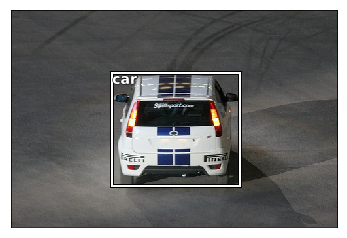

In [108]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]]) # b[:2] is top-left; im0_a[1] is class

So because Matplotlib has an OO API, we can just create an `axis` object in `draw_text`, and pass that off to `draw_outline` to draw an outline around it. Same for the bounding box: `draw_rect` creates an `axis` object called `patch` that it sends to `draw_outline` which puts a black outline around the white rectangle.

Matplotlib calls `.add_patch` on an `axis` object to draw a rectangle via a `patches.Rectangle` argument.

What's great is now that we have all that set up, we can use it for all our Object Detection work going forward! So let's package that all up a bit for quick use later.

In [109]:
# draw image with annotations
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:  # destructuring assignment
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

# draw image at a particular index
def draw_idx(i):
    im_a = trn_anno[i]  # grab img ID
    im = open_image(IMG_PATH/trn_fns[i]) # open image
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


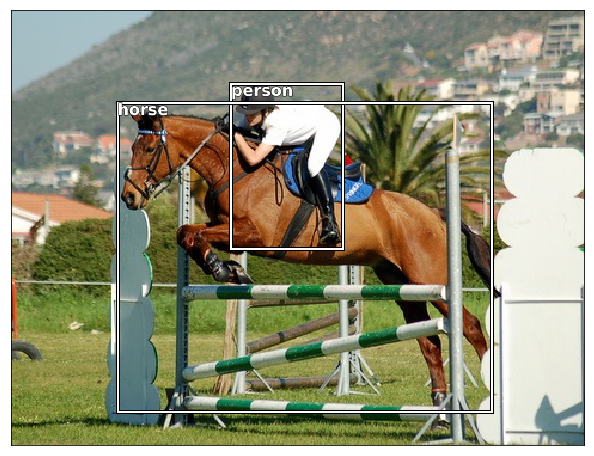

In [110]:
draw_idx(17)

## 2. Largest Item Classifier

A *λambda function* is simply a way to define an anonymous function inline. Here we use it to describe how to sort the annotation for each image - by bounding box size (descending).

In [111]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:] - x[0][:2]), reverse=True)
    return b[0]

In [112]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

Here's something cool -- J.Howard started with the second line, above, then wrote the first. He started with the API he wanted to work with -- then implemented it.

Something that takes all of the bounding boxes for a particular image and finds the largest.

He does that by sorting the bounding boxes via: the product of the difference of the last two items of the bounding-box lis (bottom-right corner) and the first two items (top-left corner). (bot-right) minus (top-left) = width and height; product of that = size of the bounding box. **Cool.**

Now we have a dictionary from image id to a single bounding box - the largest for that image.

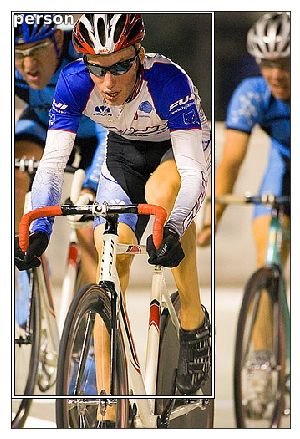

In [113]:
b, c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

It's very important to look at your work at every stage in the pipeline.

In [114]:
(PATH/'tmp').mkdir(exist_ok=True) # making a new folder in our directory
CSV = PATH/'tmp/lrg.csv'  # path to large-objects csv file

Often it's easiest to simply create a CSV of the data you want to model, rather than trying to create a custom dataset. here we use Pandas to help us create a CSV of the image filename and class. Basically: we already have a `ImageClassifierData.from_csv` method, there's no reason to build a custom dataloader; just put the labels & ids into a CSV file.

--> this is actually exactly what I did for my GLoC Detector.

Below: easiest way to create CSV: Pandas dataframe. Create as dictionary of 'name of column' : 'list of things in that column'. `columns` is specified even though columns are already given becaues dictionaries are unordered -- and order matters here.

--> Learned that the hard way in my GLoC Detector.

In [115]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 
                   'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [116]:
f_model = resnet34
sz = 224
bs = 64

From here on it's jus tlike Dogs vs Cats! We have a CSV file containing a bunch of file names, and for each one: the class and bounding box.

In [117]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

In [118]:
x, y = next(iter(md.val_dl))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


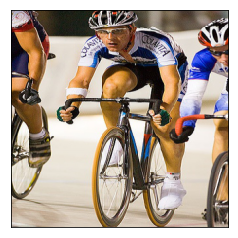

In [120]:
show_img(md.val_ds.denorm(to_np(x))[0]);